In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.aqua.utils.circuit_factory import CircuitFactory
from exp_a4 import A4Factory
from exp_a23 import A23Factory
from exp_a1 import A1Factory
import numpy as np
from qiskit.tools.visualization import circuit_drawer
from scipy.linalg import expm
%matplotlib inline
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.circuits.gates import mct
# import FTSDFactory

In [2]:
class FTSDFactory(CircuitFactory):
    """
    When no time is provided the simulation runs for t=1. The target qubit is the less significant one.
    """
    def __init__(self, num_target_qubits=1):
        super().__init__(num_target_qubits)

    def required_ancillas(self):
        return 0

    def required_ancillas_controlled(self):
        return 0
    
    def build(self, qc, q, q_ancillas=None, params=1):
        pass
        # qc.u3(params, -np.pi/2, np.pi/2, q[0])

    def build_controlled(self, qc, q, q_control, q_ancillas=None, t=1, kj=1, coefficient = [], matrix_index = []):
        if len(coefficient) != len(matrix_index):
            exit("Error.")
        a1 = A1Factory(n)
        a23 = A23Factory(n)
        a4 = A4Factory(n)
        
        for j in range(kj):
          for i in range(len(matrix_index)):
            qc.barrier()
            if matrix_index[i] == 0:
                a1.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj)
            elif matrix_index[i]==1:
                a23.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj)
            elif matrix_index[i]==2:
                a4.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj)
            else:
                exit("Wrong matrix index: ", i)

    def build_inverse(self, qc, q, q_ancillas=None, params=1):
        pass
        # self.build(qc, q, q_ancillas, -params)

    def build_controlled_inverse(self, qc, q, q_control, q_ancillas=None, params=1):
        self.build_controlled(qc, q, q_control, q_ancillas, -params)

In [3]:
def inverseindexvector(vector):
    m = len(vector)
    invector = np.zeros(m-1)
    #Reorder the vector from m starting and ending with 1, we delete the first element of the vector!
    for i in range(m-1):
        invector[i] = vector[m-i-1] 
    return invector
    

def TS_matrixindex(indexvector, coefficientvector, trotterstepsize):
    M = trotterstepsize
    m = len(indexvector)-1
    trottervector = [] #Naming is irrelevant to meaning
    suzukivector = [] #Naming is irrelevant to meaning
    repvector = np.zeros(2*m-1)
    rep2vector = np.zeros(2*m-1)
    
    #The first value is the same as the index vector
    trottervector = np.append(trottervector, indexvector[0])
    suzukivector = np.append(suzukivector, coefficientvector[0])
    opvector = inverseindexvector(indexvector)
    op2vector = inverseindexvector(coefficientvector)
    #Inside the Repetition (~~~)^M
    #repvector=np.arange(m)[1:]
    #reverser = repvector[::-1][1:]
    #np.concatenate([repvector, reverser])
    
    for i in range(m):
        repvector[i]=indexvector[i+1]
        rep2vector[i]=coefficientvector[i+1]/(2*M)
        
    for i in range(m):
        repvector[m+i-1]=opvector[i]
        rep2vector[m+i-1]=op2vector[i]/(2*M)
        if i == 0:
            rep2vector[i] = 2*rep2vector[i]
    
    print(repvector)
    print(rep2vector)
    
    for i  in range(M):
        trottervector = np.append(trottervector, repvector)
        suzukivector = np.append(suzukivector, rep2vector)
    return (trottervector, suzukivector)

In [4]:
# number of qubits n, where size of the matrix is 2**n
n = 2
#Some other parameters
t = 1 #Time
m =  10 #Trotter Steps

# number of ancilla qubits for the unitary operations themselves
n_ancilla = n-1
# number of ancilla qubits for controlling the unitary operations
n_a_con = 1

#vector for kvec
k_vec = [1]

# vector for the parameters of the matrices
coefficientmatrix=[np.pi/8, np.pi/8,  np.pi/8,  np.pi/8]
#coefficient = np.zeros(2*len(coefficientmatrix)-1)

#vector for the type of matrix to calculate
inputmatrix=[0, 1, 2, 1]
#matrix_index = np.zeros(2*len(inputmatrix)-1)

#calculate matrix index for m Trotter steps
(matrix_index, coefficient) = TS_matrixindex(inputmatrix, coefficientmatrix, m)

[1. 2. 1. 2. 1.]
[0.03926991 0.01963495 0.01963495 0.01963495 0.01963495]


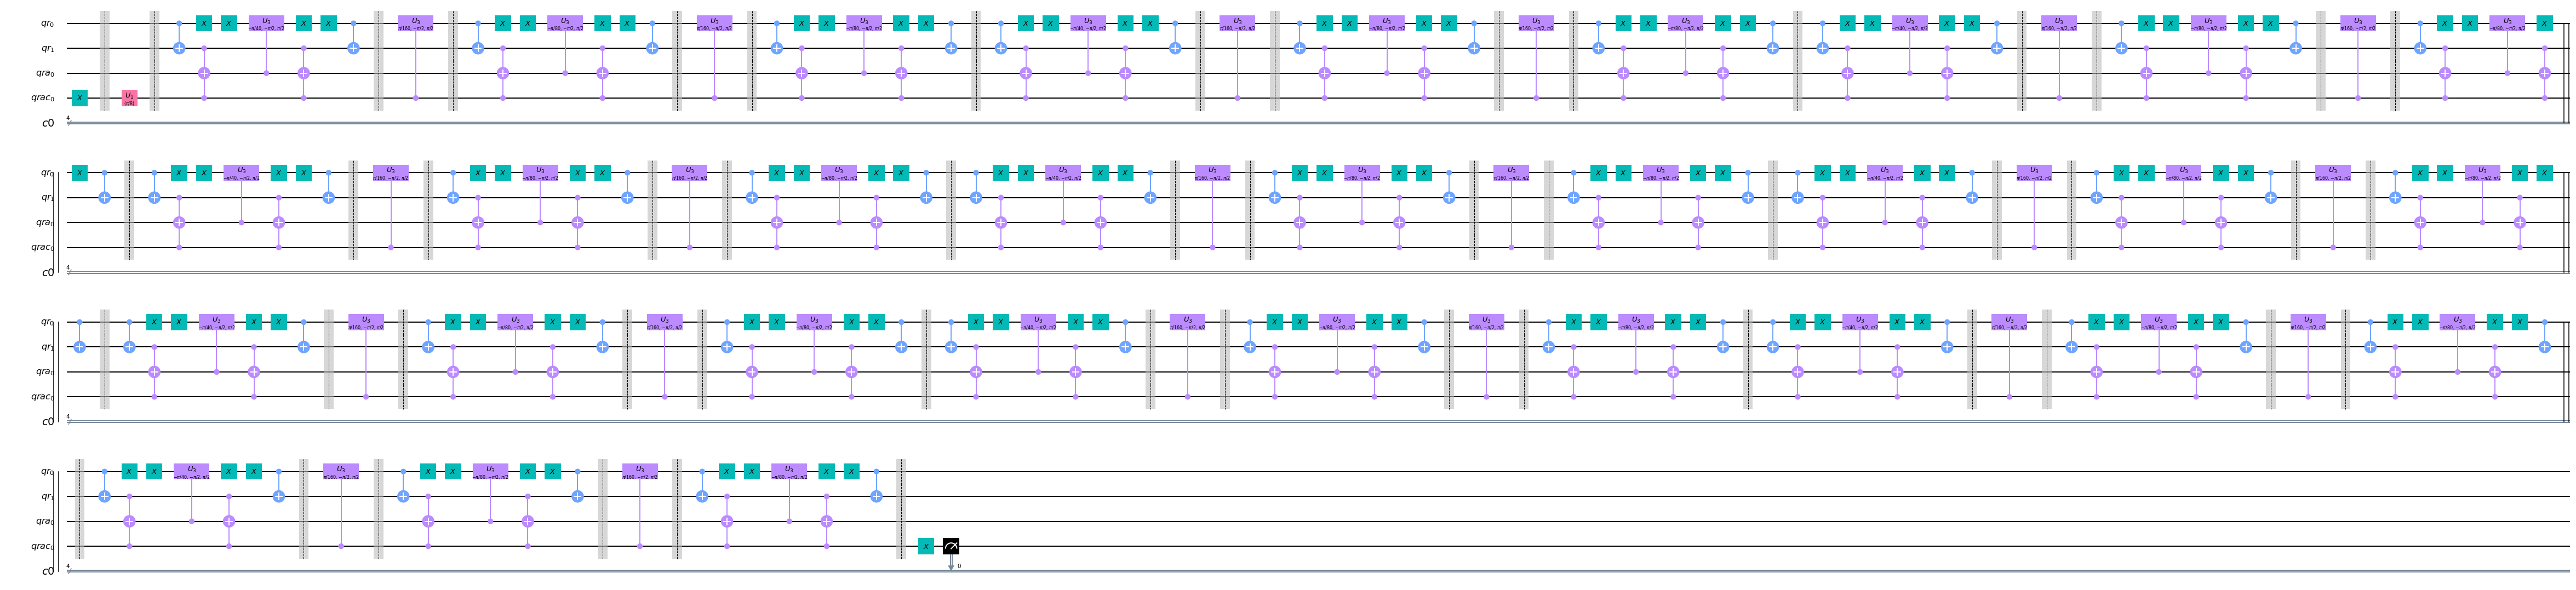

In [5]:
def get_circuit_1907p11679(t, k_vec):
    qr = QuantumRegister(n, 'qr')
    qra =  QuantumRegister(n_ancilla, 'qra')
    qrac = QuantumRegister(n_a_con, 'qrac')
    cr = ClassicalRegister(n+n_ancilla+n_a_con)
    qc = QuantumCircuit(qr, qra, qrac, cr)
    kj = k_vec[0]
    
    qc.x(qrac)
    FTSDFactory(n).build_controlled(qc, qr, qrac[0], qra, t=t, kj=k_vec[0], coefficient=coefficient, matrix_index=matrix_index)
    qc.barrier()
    qc.x(qrac)
    qc.measure(qrac, cr[0])
    qc.draw(output='mpl')
    return qc

qc = get_circuit_1907p11679(t=1, k_vec=k_vec)
qc.draw(output='mpl', fold=100)

In [6]:
# Optional: send the simulation to ibm's simulator
from qiskit import IBMQ
from qiskit import BasicAer
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-hub-ntu')
#backend = provider.get_backend('ibmq_qasm_simulator')
#backend = BasicAer.get_backend('qasm_simulator')

In [7]:
def get_approx_solution(t=1, k_vec=k_vec):
    # Obtain vector from the circuit
    backend = BasicAer.get_backend('statevector_simulator')
    # Create a quantum circuit
    qc = get_circuit_1907p11679(t=t, k_vec=k_vec)
    # Create a Quantum Program for execution 
    job = execute(qc, backend)
    # and store the result
    result = job.result()
    # Remember its an...a0qn..q0, where the a's are the ancilla
    svect = result.get_statevector(qc)

    # total number of qubits in the circuit
    lastq = n+n_ancilla+n_a_con

    formatstr = "{0:0"+str(lastq)+"b}"
    # Final vector (i.e. approximate solution of e^iHt |x>)
    approx_sol = [0]*(2**n)

    totalnorm= 0
    for i in range(0, len(svect)):
        # Only consider the entries where the sum qubits are 0 (i.e. successful circuit)
        if formatstr.format(i)[0:n_ancilla] == '0'*(n_a_con):
#             totalnorm += np.real(svect[i]*np.conjugate(svect[i]))
#             current_index = int(formatstr.format(i)[lastq-n:lastq][::-1], 2)
#             approx_sol[current_index] += svect[i]
            totalnorm += np.real(svect[i]*np.conjugate(svect[i]))
            index_bit = formatstr.format(i)[-n:][::-1]
            index_bit = ''.join(list(reversed(index_bit.strip())))
            current_index = int(index_bit, 2)
            approx_sol[current_index] += svect[i]
    
    approx_sol = approx_sol/np.sqrt(totalnorm)
    return approx_sol

In [8]:
def get_analytical_solution(t=1, initial_vector=np.append(1, [0]*((2**n)-1))):
    # analytical case
#     H23 = np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
#     H4 = np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)

#     exact_exp = expm(1j*(H23+H4)*t)

#     test = np.dot(exact_exp, np.append(1,[0]*((2**n)-1)))
#     test /= np.linalg.norm(test)
#     return test

    H_sum = np.zeros(shape=[2**n, 2**n], dtype='float32')
    for i in range(len(inputmatrix)):
        if matrix_index[i] == 0:
            b_1 = -coefficientmatrix[i]*t            
            H_sum += np.diag(np.array([b_1]*(2**n)))
        elif matrix_index[i]==1:
            b_2 = coefficientmatrix[i]*t
            H_sum += np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
        elif matrix_index[i]==2:
            b_4 = coefficientmatrix[i]*t/2
            H_sum += np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)
        else:
            exit("Wrong matrix index: ", i)
    
    #H_sum /= np.linalg.norm(H_sum, ord=2)
    exact_exp = expm(-1j * H_sum * t * 1)

    ret = np.dot(exact_exp, initial_vector)
    ret /= np.linalg.norm(ret)
    #print(H_sum)
    return ret

In [9]:
np.set_printoptions(precision=4)
print("approx: ", get_approx_solution(t=1, k_vec=k_vec))
print("exact: ", get_analytical_solution(t=1))
approx = get_approx_solution(t=1, k_vec=k_vec)
exact = get_analytical_solution(t=1)
errors = approx - exact
print(np.linalg.norm(errors, ord=2))

approx:  [0.907 +0.3757j 0.0675-0.1629j 0.0656+0.0272j 0.0019-0.0045j]
exact:  [ 0.907 +0.3757j  0.0672-0.1623j -0.0672-0.0278j -0.0019+0.0045j]
0.14411488928823568
